<a href="https://colab.research.google.com/github/Vasilevykh-M/ResNet18/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%load_ext tensorboard
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

# Torchvision
import torchvision.datasets as dset
from torchvision import datasets
from torchvision import transforms

# Torchinfo
from torchinfo import summary

In [ ]:
# Для повторяемости
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
# Если в системе есть gpu, будем считать на cuda. В противном случае - на cpu.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
DATA_PATH = 'IntroPytorch/data/'
TENSORBOARD_DIR = 'IntroPytorch/tensorboard'
CHECKPOINTS_DIR = 'IntroPytorch/checkpoints'

! mkdir -p {CHECKPOINTS_DIR} {TENSORBOARD_DIR} {CHECKPOINTS_DIR} {DATA_PATH}

In [ ]:
!gdown 'https://docs.google.com/uc?export=download&id=1E_ekMjtQ-kYnrbkpELGa9LtVnU9X_sSJ' -O 'data.zip'

Downloading...
From: https://docs.google.com/uc?export=download&id=1E_ekMjtQ-kYnrbkpELGa9LtVnU9X_sSJ
To: /content/data.zip
100% 236M/236M [00:04<00:00, 58.0MB/s]


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: flowe

In [ ]:
!mv flowers {DATA_PATH} # пихаем папку куда нам надо

In [ ]:
valid_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

# Денормализация (для визуализации)
unnorm = transforms.Normalize(mean=[-0.43/0.2,-0.44/0.2,-0.47/0.2],
                              std=[1/0.20,1/0.20,1/0.20])

In [ ]:
os.path.join(DATA_PATH, 'flowers')

'IntroPytorch/data/flowers'

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'flowers'), transform=train_transform)
val_dataset =  datasets.ImageFolder(os.path.join(DATA_PATH, 'flowers'), transform=valid_transform)

train_size = round(len(train_dataset) * 0.7)

indices = list(range(len(train_dataset)))
np.random.shuffle(indices)

train_idx, valid_idx = indices[:train_size], indices[train_size:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, sampler=train_sampler,
)
val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, sampler=valid_sampler
)

In [ ]:
len(train_sampler)

3022

In [ ]:
len(valid_sampler)

1295

In [ ]:
train_dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
# Смотрим что из себя представляет картинка
print(train_dataset[0][0].shape)

torch.Size([3, 224, 224])


tensor(0)
tensor(1)
tensor(1)
tensor(3)
tensor(4)
tensor(0)
tensor(1)
tensor(3)
tensor(4)
tensor(0)


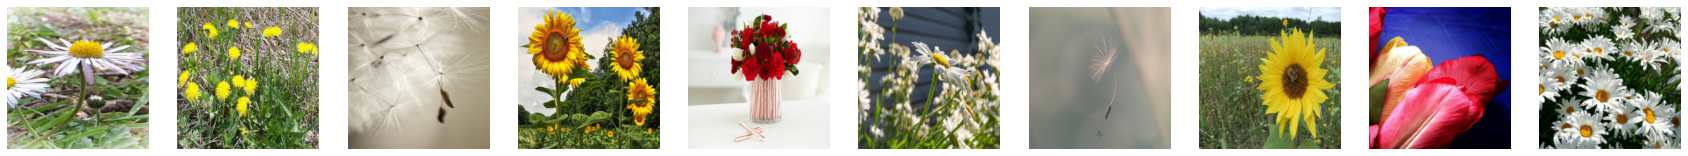

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Xb, yb = next(iter(train_dl))

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(zip(Xb, yb)):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(torch.movedim(unnorm(x),0,2))
    plt.axis('off')
    print(y)

tensor(1)
tensor(1)
tensor(2)
tensor(0)
tensor(4)
tensor(3)
tensor(1)
tensor(4)
tensor(3)
tensor(0)


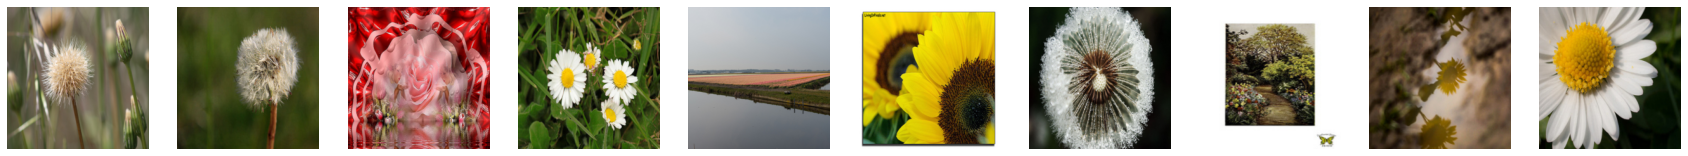

In [ ]:
Xb, yb = next(iter(val_dl))

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(zip(Xb, yb)):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(torch.movedim(unnorm(x),0,2))
    plt.axis('off')
    print(y)

In [ ]:
import torch.nn as nn
from torchinfo import summary
import torch.nn.functional as F

In [ ]:
class ResModule(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(ResModule, self).__init__()
    self.in_channels = in_channels

    self.conv2d_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride = stride, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.LeakyReLU(inplace = True)
    self.conv2d_2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.skip= nn.Sequential()
    if stride != 1 or in_channels != out_channels:    # если переходим с слоя на слой то меняем размер
      self.skip = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, padding = 0, stride = stride, bias = False),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, input):
    res = self.relu(self.bn1(self.conv2d_1(input)))
    res = self.bn2(self.conv2d_2(res))
    return self.relu(res + self.skip(input))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            ResModule(64, 64),   # default stride = 1
            ResModule(64, 64),   # default stride = 1
          )


        self.layer3 = nn.Sequential(
            ResModule(64, 128, 2),
            ResModule(128, 128),  #defaukr stride = 1
        )


        self.layer4 = nn.Sequential(
            ResModule(128, 256, 2),
            ResModule(256, 256),  #defaukr stride = 1
        )

        self.layer5 = nn.Sequential(
            ResModule(256, 512, 2),
            ResModule(512, 512),  #defaukr stride = 1
        )

        self.AMP= nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1000)
        self.fc3 = nn.Linear(1000, 5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.AMP(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        out = F.dropout(out, training=self.training)
        out = self.fc3(out)
        return F.log_softmax(out,dim=1)

In [ ]:
model = ConvNet().to(device)
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): ResModule(
      (conv2d_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2d_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (1): ResModule(
      (conv2d_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
BATCH_SIZE = 16
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [16, 5]                   --
├─Sequential: 1-1                        [16, 64, 111, 111]        --
│    └─Conv2d: 2-1                       [16, 64, 222, 222]        9,472
│    └─BatchNorm2d: 2-2                  [16, 64, 222, 222]        128
│    └─ReLU: 2-3                         [16, 64, 222, 222]        --
│    └─MaxPool2d: 2-4                    [16, 64, 111, 111]        --
├─Sequential: 1-2                        [16, 64, 111, 111]        --
│    └─ResModule: 2-5                    [16, 64, 111, 111]        --
│    │    └─Conv2d: 3-1                  [16, 64, 111, 111]        36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 111, 111]        128
│    │    └─LeakyReLU: 3-3               [16, 64, 111, 111]        --
│    │    └─Conv2d: 3-4                  [16, 64, 111, 111]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 111, 111]        128
│

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
writer = SummaryWriter(log_dir=TENSORBOARD_DIR)

for epoch in range(10):
    train_loss = 0
    val_loss = 0

    train_correct = 0
    val_correct = 0

    # Бежим по пакетам (batches)
    model.train()
    for i, (X, y) in enumerate(train_dl):
        # Глобальный номер шага
        step_idx = epoch * len(train_dl) + i
        # Перенос батча на gpu
        X_gpu = X.to(device)
        y_gpu = y.to(device)
        # Предсказание
        y_pred = model(X_gpu)
        l_gpu = loss(y_pred, y_gpu)
        # Зануляем градиент
        optimizer.zero_grad()
        # Расчёт градиентов
        l_gpu.backward()
        # Оптимизация
        optimizer.step()
        # Считаем средний лосс
        l_gpu_item = l_gpu.cpu().item()
        train_loss += l_gpu_item * len(y)
        # Считаем accuracy
        train_correct += (y_pred.argmax(dim=1) == y_gpu).float().sum()
        # Пополнение tensorboard
        writer.add_scalar('loss/train/step', l_gpu_item, step_idx)

    # Считаем ошибку на валидационной выборке
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(val_dl):
            # Глобальный номер шага
            step_idx = epoch * len(val_dl) + i
            # Перенос батча на gpu
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            # Предсказание
            y_pred = model(X_gpu)
            l_gpu = loss(y_pred, y_gpu)
            # Считаем средний лосс
            l_gpu_item = l_gpu.cpu().item()
            val_loss += l_gpu_item * len(y)
            # Считаем accuracy
            val_correct += (y_pred.argmax(dim=1) == y_gpu).float().sum()
            # Пополнение tensorboard
            writer.add_scalar('loss/val/step', l_gpu_item, step_idx)

    avg_train_loss = train_loss / len(train_sampler)
    train_acc = train_correct / len(train_sampler)

    avg_val_loss = val_loss / len(valid_sampler)
    val_acc = val_correct / len(valid_sampler)

    print(f'epoch: {epoch} - train_loss: {avg_train_loss:.5f} - train_acc: {train_acc:.5f} - val_loss: {avg_val_loss:.5f} - val_acc: {val_acc:.5f}')

    writer.add_scalar('loss/train/epoch', avg_train_loss, epoch)
    writer.add_scalar('loss/val/epoch', avg_val_loss, epoch)

    writer.add_scalar('accuracy/train/epoch', train_acc, epoch)
    writer.add_scalar('accuracy/val/epoch', val_acc, epoch)

print("\n", model)

epoch: 0 - train_loss: 1.55938 - train_acc: 0.37492 - val_loss: 1.32001 - val_acc: 0.46023
epoch: 1 - train_loss: 1.32942 - train_acc: 0.45764 - val_loss: 1.26258 - val_acc: 0.45405
epoch: 2 - train_loss: 1.21815 - train_acc: 0.51059 - val_loss: 1.29465 - val_acc: 0.50270
epoch: 3 - train_loss: 1.17138 - train_acc: 0.53739 - val_loss: 1.10360 - val_acc: 0.58301
epoch: 4 - train_loss: 1.11095 - train_acc: 0.55692 - val_loss: 1.08266 - val_acc: 0.60000
epoch: 5 - train_loss: 1.08675 - train_acc: 0.56155 - val_loss: 1.11130 - val_acc: 0.57915
epoch: 6 - train_loss: 1.01884 - train_acc: 0.59530 - val_loss: 1.01048 - val_acc: 0.60849
epoch: 7 - train_loss: 1.02742 - train_acc: 0.59431 - val_loss: 1.07610 - val_acc: 0.60077
epoch: 8 - train_loss: 1.01735 - train_acc: 0.60192 - val_loss: 1.36838 - val_acc: 0.52355
epoch: 9 - train_loss: 0.98290 - train_acc: 0.61052 - val_loss: 0.96698 - val_acc: 0.64170

 ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1